In [1]:
!pip uninstall opencv-python -y
# downgrade OpenCV a bit to use SIFT
!pip install opencv-contrib-python==3.4.2.17 --force-reinstall --user
!pip install ffmpeg-python --user
# for converting to video

Skipping opencv-python as it is not installed.


  Using cached https://files.pythonhosted.org/packages/10/58/8433265d728cb603dc41c6ba04515c31ab14e490a55c4a654638e2ba9f6f/opencv_contrib_python-3.4.2.17-cp37-cp37m-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/9a/e3/56f6241cf309ff2f6d1df97fc0ba42a156526efa09261ee53f08521b7da3/numpy-1.21.4-cp37-cp37m-win_amd64.whl
  Found existing installation: numpy 1.21.4
    Uninstalling numpy-1.21.4:


tables 3.5.1 requires mock>=2.0, which is not installed.
  The script f2py.exe is installed in 'C:\Users\tonyy\AppData\Roaming\Python\Python37\Scripts' which is not on PATH.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


      Successfully uninstalled numpy-1.21.4
  Found existing installation: opencv-contrib-python 3.4.2.17
    Uninstalling opencv-contrib-python-3.4.2.17:
      Successfully uninstalled opencv-contrib-python-3.4.2.17


In [133]:
import scipy
import scipy.sparse.linalg
import ffmpeg
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from skimage import draw
from multiprocessing import Pool, TimeoutError
import pickle
import os
from numpy.linalg import svd, inv

In [279]:
# jupyter extension that allows reloading functions from imports without clearing kernel :D
%reload_ext autoreload
%autoreload 2
utilfn = "./utils.py"
import utils

Idea 1: Cross-Dissolve

In [343]:
def crossDissolve(sourceImg, targetImg, timelength):
    assert sourceImg.shape == targetImg.shape
    video_name = 'crossDissolve.mp4'
    H, W, C = targetImg.shape
    video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'MP4V'), 30, (W,H))
    #Imagehalfway = (1-t)*Image1 + t*image2
    timelengthfps = timelength * 30
    for i in range (timelengthfps):
        halfImg = (timelengthfps - i) / timelengthfps * sourceImg + i / timelengthfps * targetImg
        if i == timelength * 10:
            halfImg1 = halfImg
        if i == timelength * 20:
            halfImg2 = halfImg
        video.write(np.uint8(halfImg))
    cv2.destroyAllWindows()
    video.release()
    return halfImg1, halfImg2
    

In [344]:
sourceImg = cv2.imread('./images/inputs/river1.jpg')
targetImg = cv2.imread('./images/inputs/river2.jpg')
halfImg1, halfImg2 = crossDissolve(sourceImg, targetImg, 5)


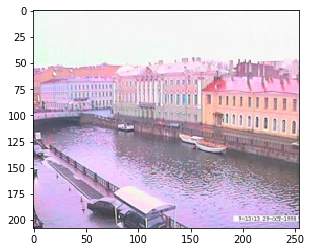

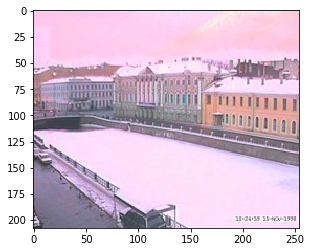

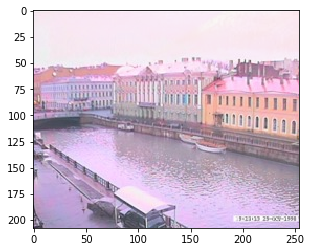

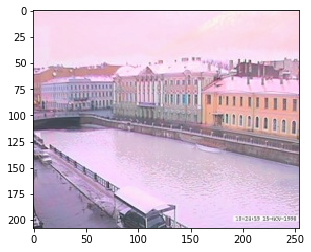

In [345]:
%matplotlib inline
plt.imshow(np.uint8(sourceImg[:,:,[2,1,0]]))
plt.show()
plt.imshow(np.uint8(targetImg[:,:,[2,1,0]]))
plt.show()
plt.imshow(np.uint8(halfImg1[:,:,[2,1,0]]))
plt.show()
plt.imshow(np.uint8(halfImg2[:,:,[2,1,0]]))
plt.show()

Idea 2: Align, then cross-disolve!

In [315]:
def computeHomography(pts1, pts2,normalization_func=None):
    A = np.zeros((2*pts1.shape[1], 9))
    for i in range (A.shape[0]):
        i_2 = i//2
        if i % 2 == 0:
            A[i,0] = -pts1[0, i_2]
            A[i,1] = -pts1[1, i_2]
            A[i,2] = -1
            A[i,6] = pts1[0, i_2] * pts2[0, i_2]
            A[i,7] = pts1[1, i_2] * pts2[0, i_2]
            A[i,8] = pts2[0, i_2]
        else: 
            A[i,3] = -pts1[0, i_2]
            A[i,4] = -pts1[1, i_2]
            A[i,5] = -1
            A[i,6] = pts1[0, i_2] * pts2[1, i_2]
            A[i,7] = pts1[1, i_2] * pts2[1, i_2]
            A[i,8] = pts2[1, i_2]
    _, _, Vt = np.linalg.svd(A)
    Vt_end = Vt.shape[0]
    h = Vt[Vt_end-1, :]
    H = h.reshape(3,3)
    return H

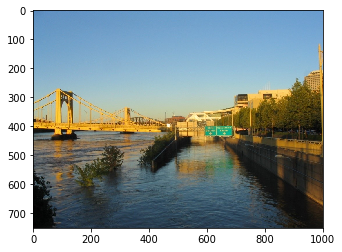

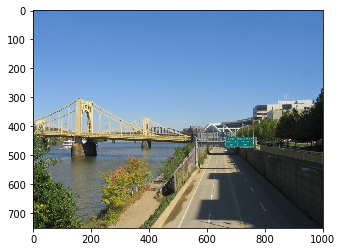

In [318]:
sourcefile= './images/inputs/bridge1.jpg'
sourceImg = cv2.imread('./images/inputs/bridge1.jpg')
targetfile= './images/inputs/bridge2.jpg'
targetImg= cv2.imread('./images/inputs/bridge2.jpg')
plt.imshow(np.uint8(sourceImg[:,:,[2,1,0]]))
plt.show()
plt.imshow(np.uint8(targetImg[:,:,[2,1,0]]))
plt.show()

In [327]:
def alignedCrossDissolve(sourceImg, targetImg, timelength):
    # H = utils.auto_homography(sourceImg,targetImg, computeHomography)
    # T = np.array([[1,0,100],[0,1,50],[0,0,1]])
    h, w, c = targetImg.shape
    # img_warped = cv2.warpPerspective(targetImg, np.dot(T,H), (4*w//3, 4*h//3))
    # background = np.uint8(np.zeros((4*h//3, 4*w//3, 3)))
    # background[:sourceImg.shape[0], :sourceImg.shape[1],:] = sourceImg
    
    background = targetImg
    img_warped = sourceImg
    
    video_name = 'alignedCrossDissolve.mp4'
    # video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'MP4V'), 30, (4*w//3, 4*h//3))
    video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'MP4V'), 30, (w, h))
    #Imagehalfway = (1-t)*Image1 + t*image2
    timelengthfps = timelength * 30
    plt.imshow(img_warped[:,:,[2,1,0]])
    plt.show()
    plt.imshow(background[:,:,[2,1,0]])
    plt.show()
    for i in range (timelengthfps):
        halfImg = np.uint8((timelengthfps - i) / timelengthfps * img_warped + i / timelengthfps * background)
        if i == timelength * 10:
            halfImg1 = halfImg
        if i == timelength * 20:
            halfImg2 = halfImg
        video.write(halfImg)
    cv2.destroyAllWindows()
    video.release()
    return halfImg1, halfImg2
    

<IPython.core.display.Javascript object>


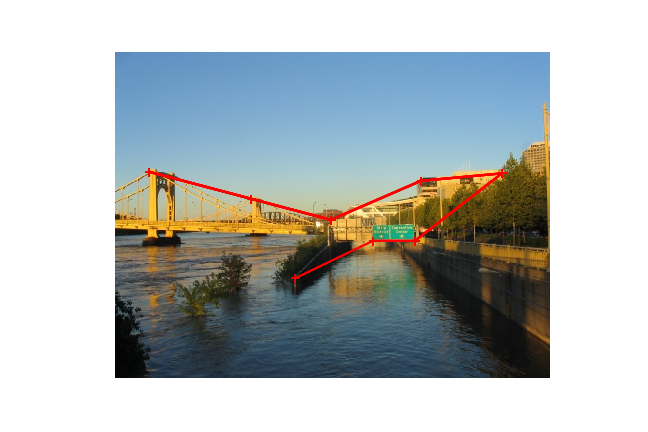

In [325]:
import utils
%matplotlib notebook  
pts_im1_8p = utils.prompt_eye_selection(sourceImg)
plt.imshow(sourceImg[:,:,[2,1,0]])

<IPython.core.display.Javascript object>


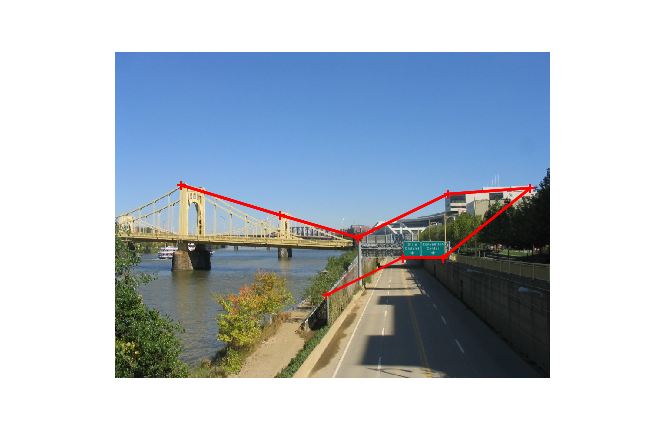

In [326]:
%matplotlib notebook
pts_im2_8p = utils.prompt_eye_selection(targetImg)
plt.imshow(targetImg[:,:,[2,1,0]])

In [330]:
constarray = np.ones((1, pts_im1_8p.shape[0])) # size(1, 10)
pts_im1 = pts_im1_8p.T # size(2,10)
pts_im1 = np.insert(pts_im1, 2, values=constarray, axis=0) # size(1, 10)
pts_im1

array([[ 78.76637, 313.62656, 496.67935, 703.90894, 890.4156 , 690.0936 ,
        593.3865 , 413.78754],
       [275.85068, 338.01956, 386.37314, 296.57364, 279.3045 , 434.72668,
        434.72668, 521.0723 ],
       [  1.     ,   1.     ,   1.     ,   1.     ,   1.     ,   1.     ,
          1.     ,   1.     ]], dtype=float32)

In [332]:
pts_im2 = pts_im2_8p.T # size(2,10)
pts_im2 = np.insert(pts_im2, 2, values=constarray, axis=0) # size(1, 10)
pts_im2

array([[151.79672, 379.74927, 559.3482 , 766.5778 , 956.53827, 756.2163 ,
        662.963  , 486.81787],
       [306.14365, 375.22018, 427.0276 , 326.8666 , 313.0513 , 473.07852,
        473.07852, 559.4242 ],
       [  1.     ,   1.     ,   1.     ,   1.     ,   1.     ,   1.     ,
          1.     ,   1.     ]], dtype=float32)

In [334]:
A= pts_im1.T
b = pts_im2[0,:].T

v = scipy.sparse.linalg.lsqr(A, b)[0]
trans1 = v.T

b = pts_im2[1,:].T
v = scipy.sparse.linalg.lsqr(A, b)[0]
trans2 = v.T

trans3 = np.zeros((1,3))
trans3[0,2] = 1

b = np.ones((1,8))
v = scipy.sparse.linalg.lsqr(A, b)[0]
v /= v[2]

trans0 = np.vstack((trans1, trans2))
trans0 = np.vstack((trans0, trans4))
trans0

array([[9.90943621e-01, 1.47078443e-02, 6.66960016e+01],
       [1.29880353e-03, 1.03380955e+00, 2.26886154e+01],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [335]:
dst = cv2.warpPerspective(sourceImg,trans0,(3*ww//2,3*hh//2))

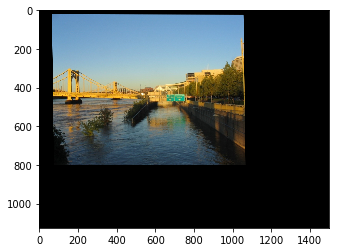

In [336]:
%matplotlib inline
plt.imshow(np.uint8(dst[:,:,[2,1,0]]))
plt.show()

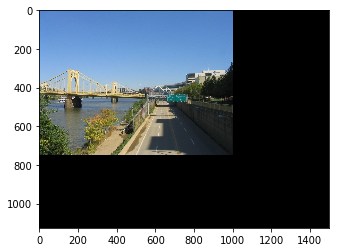

In [338]:
dst2 = np.uint8(np.zeros((3*hh//2,3*ww//2,3)))
dst2[:targetImg.shape[0],:targetImg.shape[1],:] = targetImg
%matplotlib inline
plt.imshow(np.uint8(dst2[:,:,[2,1,0]]))
plt.show()

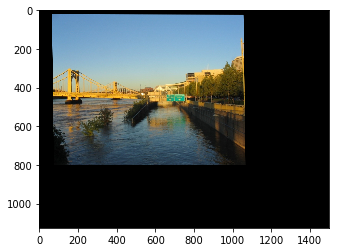

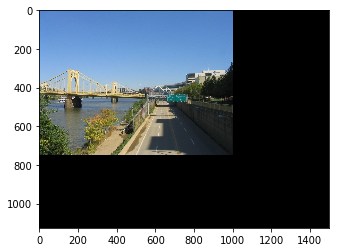

In [341]:
h1, h2 = alignedCrossDissolve(np.uint8(dst),np.uint8(dst2),5)

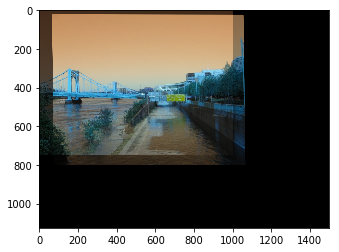

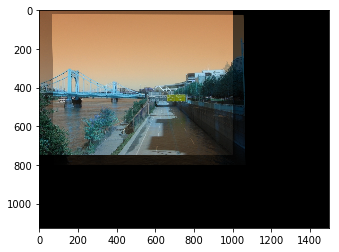

In [342]:
%matplotlib inline
plt.imshow(np.uint8(h1))
plt.show()
plt.imshow(np.uint8(h2))
plt.show()